<a href="https://colab.research.google.com/github/mohitmishra786/INT_246_Project/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


## Image Captioning with Keras and TensorFlow

Image captioning is a new technology that combines LSTM text generation with the computer vision powers of a convolutional neural network.  I first saw this technology in Andrej Karpathy's Dissertation. [[Cite:karpathy2016connecting]](https://cs.stanford.edu/people/karpathy/main.pdf) Down Given Figure shows images from his work.

**Andrej Karpathy's Dissertation**
![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/karpathy_thesis.jpg "Captioning")

In this part, we will use LSTM and CNN to create a basic image captioning system. We will use transfer learning to utilize this project:

* [InceptionV3](https://arxiv.org/abs/1512.00567)
* [Glove](https://nlp.stanford.edu/projects/glove/)

We use inception to extract features from the images.  Glove is a set of Natural Language Processing (NLP) vectors for common words. Below Figure gives a high-level overview of captioning.

We begin by importing the needed libraries.

In [ ]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

We use the following function to nicely format elapsed times.

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Needed Data

You will need to download the following data and place it in a folder for this example.  Point the *root_captioning* string at the folder that you are using for the caption generation. This folder should have the following sub-folders.

* data - Create this directory to hold saved models.
* [glove.6B](https://nlp.stanford.edu/projects/glove/) - Glove embeddings.
* [Flicker8k_Dataset](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip) - Flicker dataset.
* [Flicker8k_Text](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip)

Note, the original Flickr datasets are no longer available, but you can download them from a location specified by [this article](https://machinelearningmastery.com/prepare-photo-caption-dataset-training-deep-learning-model/). 

### Running Locally

You will need to modify the following code to reflect the folder's location that you will store files required by this captions example.


In [ ]:
if COLAB:
    root_captioning = "/content/drive/MyDrive/Image-Caption-Generator"
else:
    root_captioning = "./data/captions"

### Clean/Build Dataset From Flickr8k

We must pull in the Flickr dataset captions and clean them of extra whitespace, punctuation, and other distractions.

In [ ]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text',\
                        'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


The following code displays stats on the data downloaded and processed.

In [ ]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)


8092
8763
32


Next, we load the Glove embeddings.

In [ ]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

Display the count of how many Glove embeddings we have.

In [ ]:
len(img)

8091

Read all image names and use the predefined train/test sets.

In [ ]:
train_images_path = os.path.join(root_captioning,\
            'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

Display the size of the train and test sets.

In [ ]:
print(len(train_images))
print(len(test_images))

6000
1000


Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know the process is complete.

In [ ]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [ ]:
len(train_descriptions)

6000

### Choosing a Computer Vision Neural Network to Transfer

This example provides two neural networks that we can use via transfer learning.  In this example, I use Glove for the text embedding and InceptionV3 to extract features from the images.  Both of these transfers serve to extract features from the raw text and the images.  Without this prior knowledge transferred in, this example would take considerably more training.

I made it so you can interchange the neural network used for the images.  By setting the values **WIDTH**, **HEIGHT**, and **OUTPUT_DIM**, you can interchange images.  One characteristic that you are seeking for the image neural network is that it does not have too many outputs (once you strip the 1000-class imagenet classifier, as is common in transfer learning).  InceptionV3 has 2,048 features below the classifier, and MobileNet has over 50K.  If the additional dimensions truly capture aspects of the images, then they are worthwhile.  However, having 50K features increases the processing needed and the complexity of the neural network we are constructing.

In [ ]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96124928/96112376 [==============================] - 1s 0us/step


The summary of the chosen image neural network to be transferred is displayed.

In [ ]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Creating the Training Set

We need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

In [ ]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image 
  # encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for 
  # the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

We can how to generate the training set, which will involve looping over every JPG that we provided.  Because this can take a while to perform, we will save it to a pickle file.  This saved file prevents the considerable time needed to reprocess all of the images again.  Because the images are processed differently by different transferred neural networks, the filename contains the output dimensions. We follow this naming convention because if you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and you must reprocess the images.

In [ ]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 6000/6000 [25:39<00:00,  3.90it/s]



Generating training set took: 0:25:39.98


We must also perform a similar process for the test images.

In [ ]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


Generating testing set took: 0:04:12.60


Next, we separate the captions that we will use for training.  There are two sides to this training, the images, and the captions.

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Words that do not occur very often can be misleading to neural network training.  It is better to remove such words.  Here we remove any words that occur less than ten times.  We display the new reduced size of the vocabulary shrunk.

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next, we build two lookup tables for this vocabulary. The table **idxtoword** converts index numbers to actual words to index values.  The **wordtoidx** lookup table performs the opposite.

In [ ]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [ ]:
max_length +=2
print(max_length)

34


### Using a Data Generator

Up to this point, we've always generated training data ahead of time and fit the neural network to it.  It is not always practical to create all of the training data ahead of time.  The memory demands can be considerable.  If we generate the training data as the neural network needs it, it is possible to use a Keras generator.  The generator will create new data as it is needed.  The generator provided here creates the training data for the caption neural network, as it is needed.

If we were to build all needed training data ahead of time, it would look like CAP-WORK.

**CAP-WORK: Captioning Training Data**
![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-2.png "Captioning")

Here we are just training on two captions.  However, we would have to duplicate the image for each of these partial captions that we have.  Additionally, the Flikr8K data set has five captions for each picture.  Those would all require duplication of data as well.  It is much more efficient to generate the data as needed.

In [ ]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

### Loading Glove Embeddings

In [ ]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:09, 42731.19it/s]


Found 400000 word vectors.


### Building the Neural Network

We build an embedding matrix from Glove.  We will directly copy this matrix to the weight matrix of the neural network.

In [ ]:
embedding_dim = 50

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

The matrix dimensions make sense.  It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [ ]:
embedding_matrix.shape

(1652, 50)

In [ ]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
embedding_dim

50

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 50)       82600       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train the Neural Network

In [ ]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)
    



  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


2000/2000 [==============================] - 346s 170ms/step - loss: 4.3577


  5%|▌         | 1/20 [05:45<1:49:28, 345.73s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 3.6920


 10%|█         | 2/20 [12:07<1:50:06, 367.05s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 3.4655


 15%|█▌        | 3/20 [18:29<1:45:55, 373.86s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 3.3281


 20%|██        | 4/20 [24:16<1:36:51, 363.22s/it]

2000/2000 [==============================] - 345s 172ms/step - loss: 3.2309


 25%|██▌       | 5/20 [30:01<1:29:10, 356.67s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 3.1582


 30%|███       | 6/20 [35:47<1:22:21, 352.95s/it]

2000/2000 [==============================] - 342s 171ms/step - loss: 3.1010


 35%|███▌      | 7/20 [42:09<1:18:31, 362.44s/it]

2000/2000 [==============================] - 340s 170ms/step - loss: 3.0541


 40%|████      | 8/20 [47:49<1:11:04, 355.40s/it]

2000/2000 [==============================] - 345s 172ms/step - loss: 3.0165


 45%|████▌     | 9/20 [53:34<1:04:32, 352.09s/it]

2000/2000 [==============================] - 343s 171ms/step - loss: 2.9800


 50%|█████     | 10/20 [59:56<1:00:13, 361.31s/it]

2000/2000 [==============================] - 339s 169ms/step - loss: 2.9508


 55%|█████▌    | 11/20 [1:05:35<53:09, 354.43s/it]

2000/2000 [==============================] - 341s 170ms/step - loss: 2.9274


 60%|██████    | 12/20 [1:11:16<46:42, 350.35s/it]

2000/2000 [==============================] - 341s 171ms/step - loss: 2.9036


 65%|██████▌   | 13/20 [1:16:57<40:33, 347.59s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.8855


 70%|███████   | 14/20 [1:23:19<35:47, 357.98s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.8662


 75%|███████▌  | 15/20 [1:29:41<30:26, 365.21s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.8486


 80%|████████  | 16/20 [1:35:27<23:57, 359.29s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.8341


 85%|████████▌ | 17/20 [1:41:48<18:18, 366.11s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.8181


 90%|█████████ | 18/20 [1:48:10<12:21, 370.88s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.8043


 95%|█████████▌| 19/20 [1:54:32<06:14, 374.21s/it]

2000/2000 [==============================] - 349s 174ms/step - loss: 2.7956


100%|██████████| 20/20 [2:00:54<00:00, 362.75s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1000/1000 [==============================] - 197s 197ms/step - loss: 2.6567
\Training took: 2:40:06.71


### Generating Captions

It is essential to understand that we do not generate a caption with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable-length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which we map to the input neurons).  The first input is the photo, and the second input is an ever-growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  The caption continues to grow until the neural network predicts an end token, or we reach the maximum length of a caption.  

In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data from Flicker8k

The caption model performs relatively well on images that are similar to the training set.

/content/drive/MyDrive/Image-Caption-Generator/Flicker8k_Dataset/3191135894_2b4bdabb6d.jpg


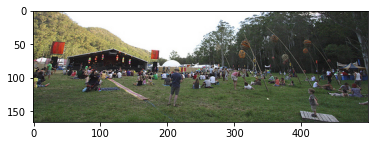

Caption: group of people are standing in front of white building
_____________________________________
/content/drive/MyDrive/Image-Caption-Generator/Flicker8k_Dataset/464251704_b0f0c4c87a.jpg


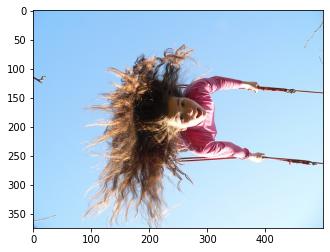

Caption: young girl in pink shirt is jumping in the air
_____________________________________


In [ ]:
for z in range(2): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [ ]:
encoding_test[pic].shape

(2048,)

### Evaluate Performance on My Photos 

In the "photos" folder of this GitHub repository, I keep a collection of personal photos that I like to use for testing neural networks.  These are entirely separate from the Flicker8K dataset, and as a result, the caption neural network does not perform nearly as well.

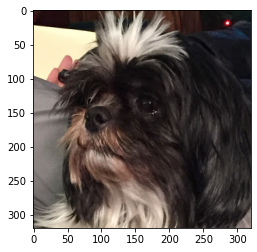

(1, 2048)
Caption: dog is running through the grass
_____________________________________


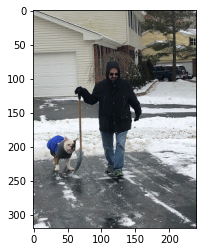

(1, 2048)
Caption: boy in red shirt and jeans is running along the street
_____________________________________


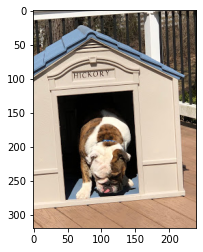

(1, 2048)
Caption: two dogs are playing in the grass
_____________________________________


In [ ]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

ROOT = "https://github.com/mohitmishra786/" + \
        "INT_246_Project/blob/main/photos/"
urls = [
  ROOT+"annie_dog.jpg?raw=true",
  ROOT+"snow_shovel.jpg?raw=true",
  ROOT+"hickory_home.jpg?raw=true"
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")

In [ ]:
pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.1.1
chardet==3.0.4
charset-normalizer==2.0.8
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.24
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
